In [1]:
from fileio import load_opt_path_bitmaps
SLURM_ID = 128762
HIDDEN_SIZES = [10, 25, 100]
NUM_RUNS = 100
NUM_OPT_POINTS = 11

In [2]:
from fileio import load_opt_path_bitmaps, load_fine_path_train_bitmaps, load_fine_path_test_bitmaps
def get_opt_paths(num_hidden, num_runs=NUM_RUNS, slurm_id=SLURM_ID, include_fine=False): 
    train_opt_path, test_opt_path = load_opt_path_bitmaps(num_hidden, 0, slurm_id)
    num_opt_points = len(train_opt_path)
    train_opt_paths = [[] for _ in range(num_opt_points)]
    test_opt_paths = [[] for _ in range(num_opt_points)]
    
    for i in range(num_runs):
        train_opt_path, test_opt_path = load_opt_path_bitmaps(num_hidden, i, slurm_id)
        for j in range(num_opt_points):
            train_opt_paths[j].append(train_opt_path[j])
            test_opt_paths[j].append(test_opt_path[j])
            
    if include_fine:
        fine_train_path = []
        fine_test_path = []
        for i in range(10):
            fine_train_path.append([load_fine_path_train_bitmaps(num_hidden, run_i, i) for run_i in range(num_runs)])
            fine_test_path.append([load_fine_path_test_bitmaps(num_hidden, run_i, i) for run_i in range(num_runs)])
        train_opt_paths = train_opt_paths[:1] + fine_train_path + train_opt_paths[1:]
        test_opt_paths = test_opt_paths[:1] + fine_test_path + test_opt_paths[1:]
        
    return train_opt_paths, test_opt_paths

In [13]:
from fileio import load_fine_path_train_bitmaps, load_fine_path_test_bitmaps
def get_fine_opt_paths(num_hidden=25, num_runs=60, num_inters=120):
    train_path = []
    test_path = []
    for i in range(num_inters + 1):
        if i % 10 == 0:
            print('{} of {}'.format(i, num_inters))
        train_path.append([load_fine_path_train_bitmaps(num_hidden, run_i, i) for run_i in range(num_runs)])
        test_path.append([load_fine_path_test_bitmaps(num_hidden, run_i, i) for run_i in range(num_runs)])
    return train_path, test_path

In [14]:
train_opt_paths, test_opt_paths = get_fine_opt_paths(25, 60, 120)

0 of 120
10 of 120
20 of 120
30 of 120
40 of 120
50 of 120
60 of 120
70 of 120
80 of 120
90 of 120
100 of 120
110 of 120
120 of 120


In [16]:
import torch

def get_probs(bitmaps_list, idxs=None, sort=False):
    bitmaps = torch.cat(bitmaps_list, dim=1)
    ps = torch.mean(bitmaps, dim=1)
    if sort:
        return torch.sort(ps)
    elif idxs is not None:
        return ps[idxs]
    elif idxs is None:
        return ps
    else:
        raise ValueError('Invalid argument combination: idxs={} with sort={}'.format(idxs, sort))

def get_sorted_probs(bitmaps_list):
    sorted_probs, _ = get_probs(bitmaps_list, sort=True)
    return sorted_probs
        
def opt_paths_to_sorted_ps(opt_paths):
    return [get_sorted_probs(opt_points_i) for opt_points_i in opt_paths]
        
def opt_paths_to_ordered_ps(opt_paths):
    _, idxs = get_probs(opt_paths[1], sort=True)
    return [get_probs(opt_points_i, idxs) for opt_points_i in opt_paths]

In [34]:
# train_ps = opt_paths_to_sorted_ps(train_opt_paths)
test_ps = opt_paths_to_sorted_ps(test_opt_paths)

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_opt_point_probs(probs, title, xlabel='examples', epoch=None, label=None):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('probability of correct prediction')
    if label is not None:
        pass
    elif epoch is not None:
        label = 'epoch {}'.format(epoch)
    else:
        label = None
    n = len(probs)
    plt.plot([i / n for i in range(n)], probs.tolist(), label=label)

In [43]:
[i / 5 for i in range(5)

[0.0, 0.2, 0.4, 0.6, 0.8]

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_opt_point_both(train_ps, test_ps, title, xlabel='examples', epoch=None, labels=None):
    plot_opt_point_probs(train_ps, title, label='train')
    plot_opt_point_probs(test_ps, title, label='test')
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

/u/nealbray/.conda/envs/inf-path/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


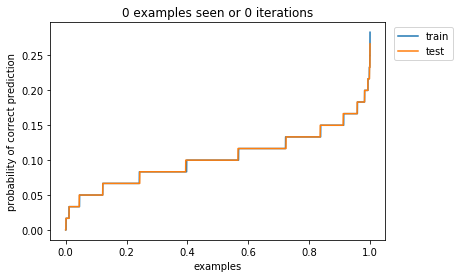

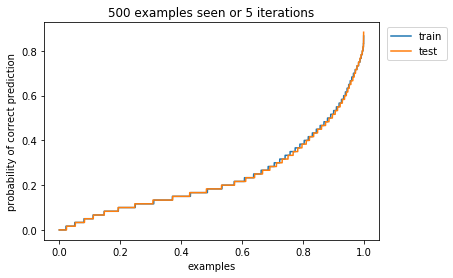

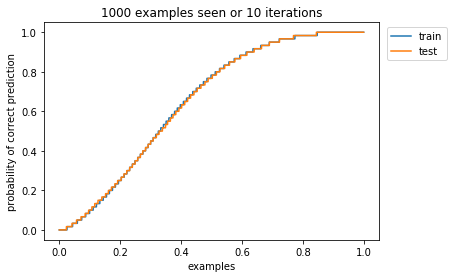

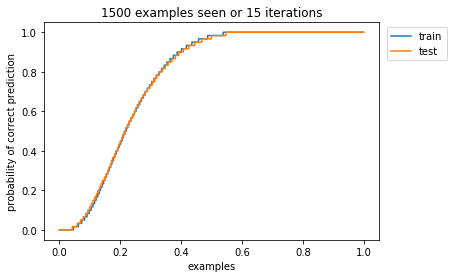

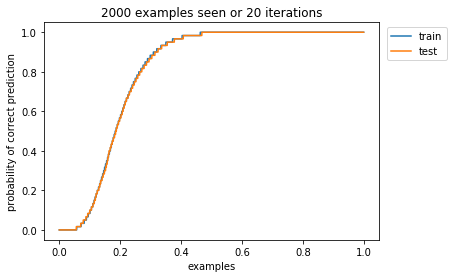

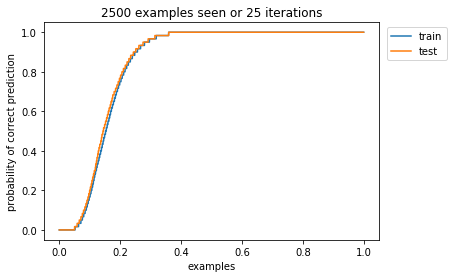

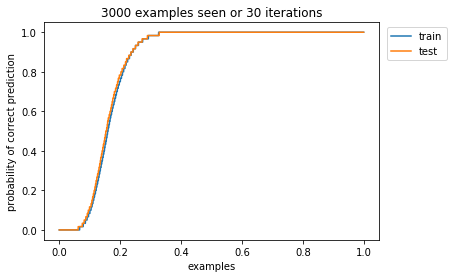

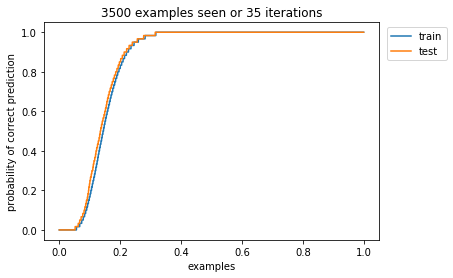

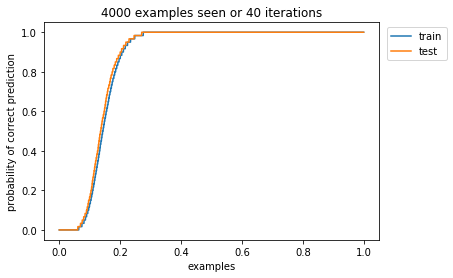

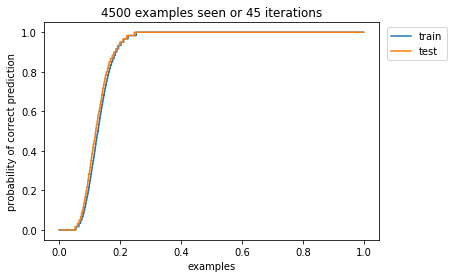

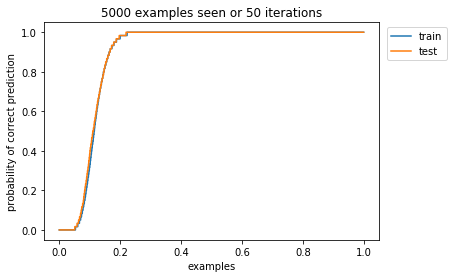

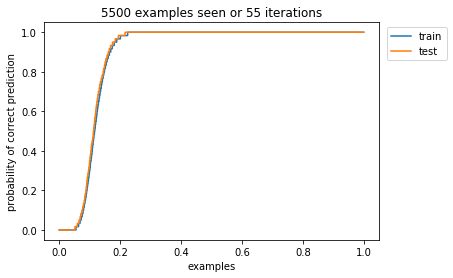

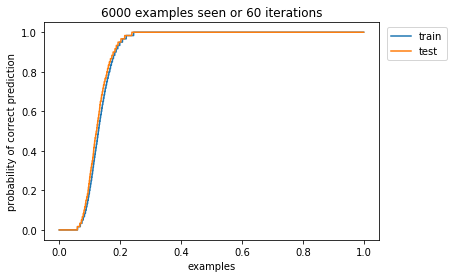

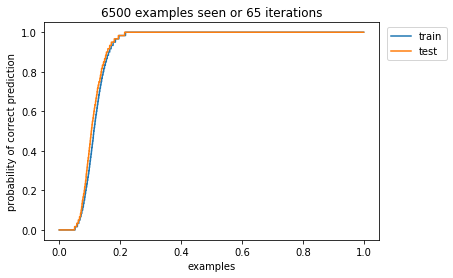

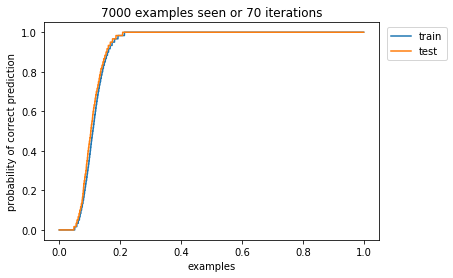

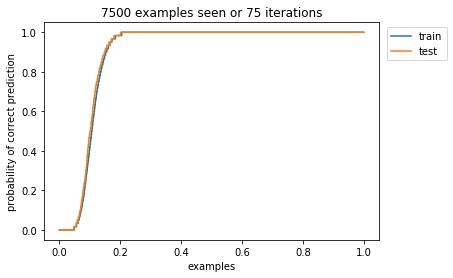

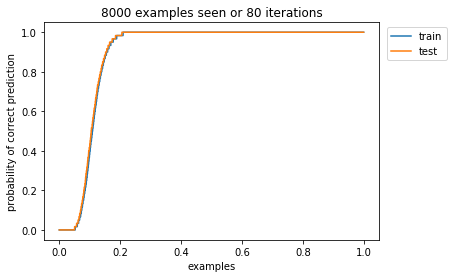

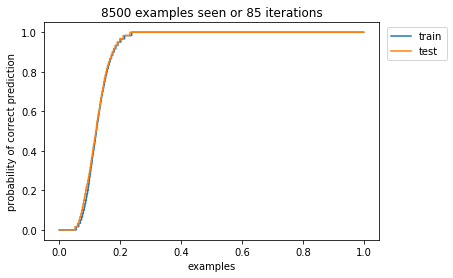

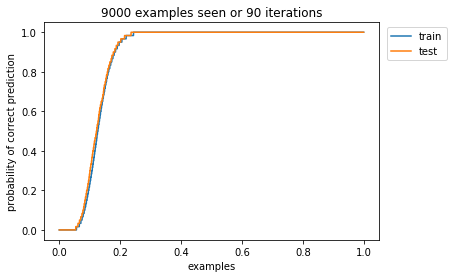

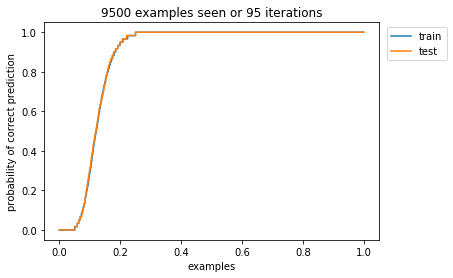

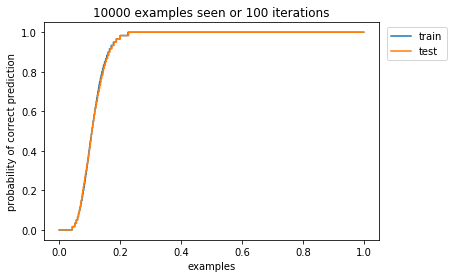

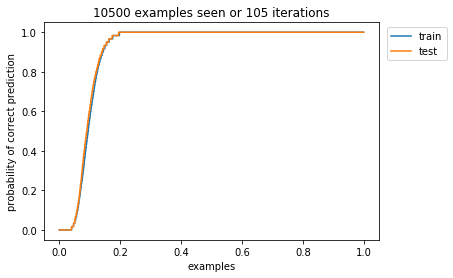

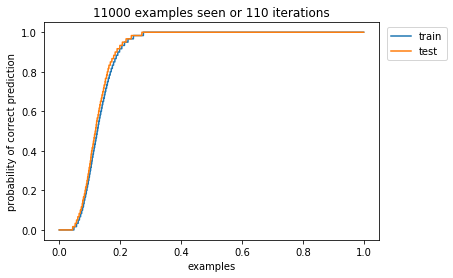

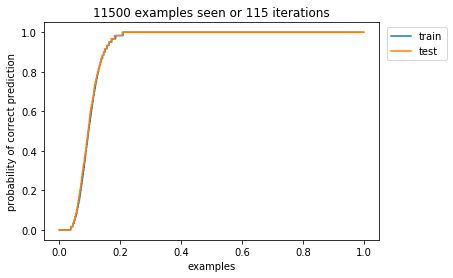

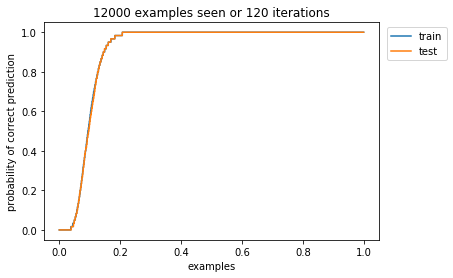

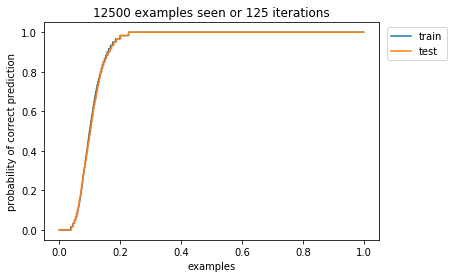

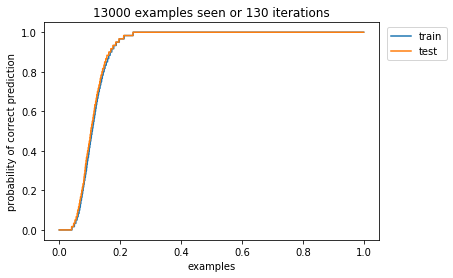

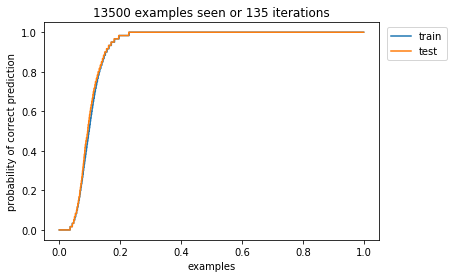

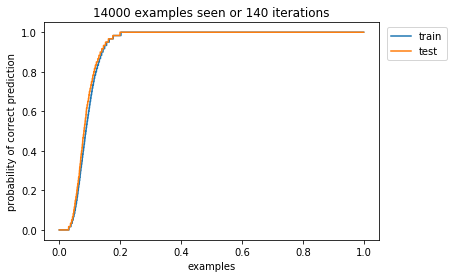

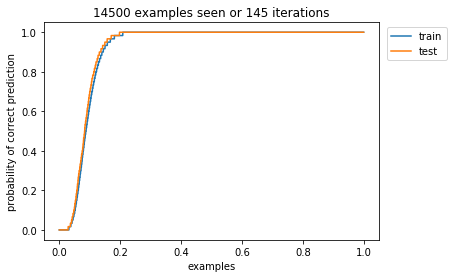

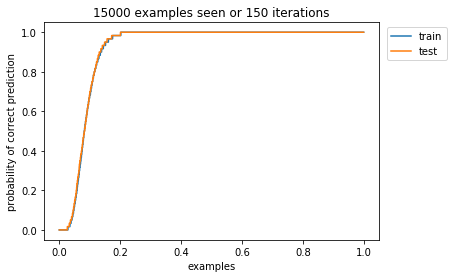

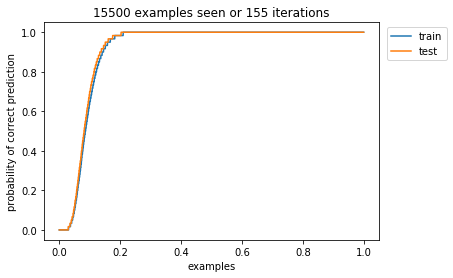

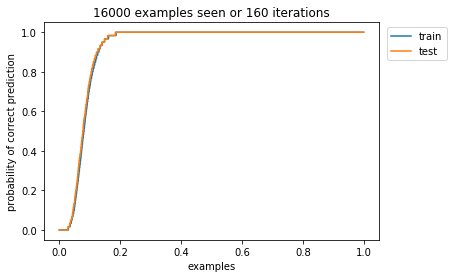

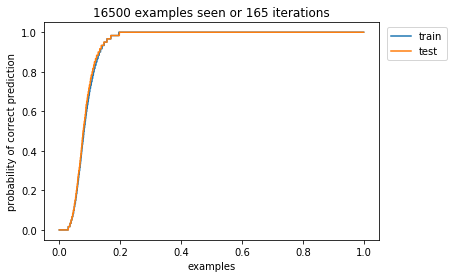

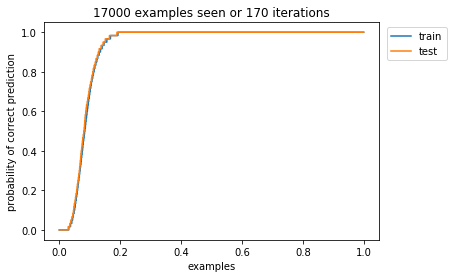

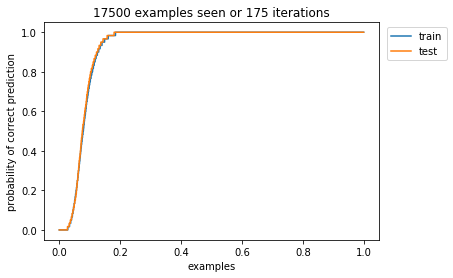

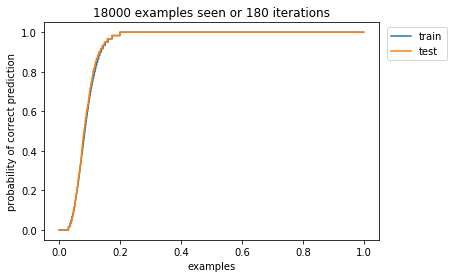

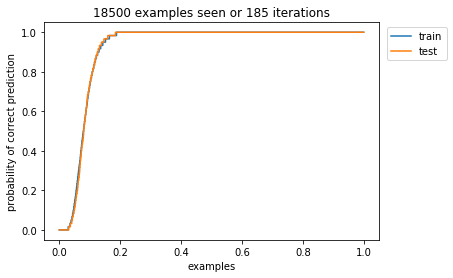

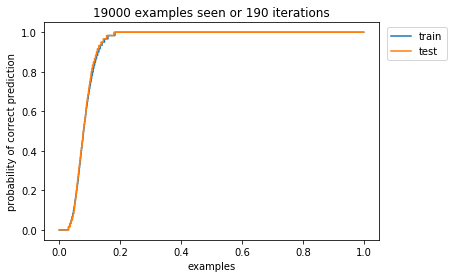

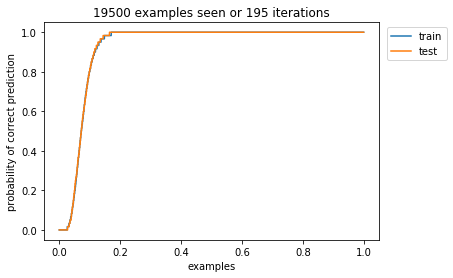

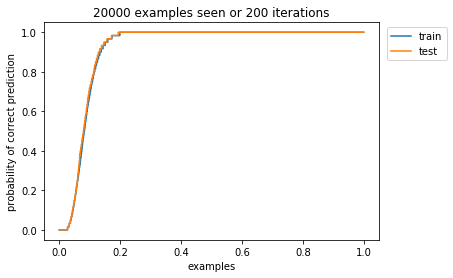

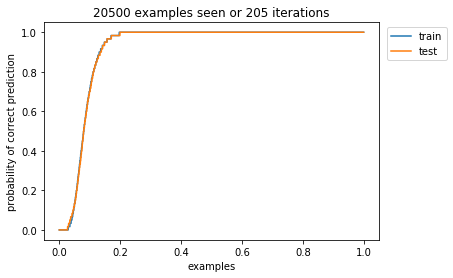

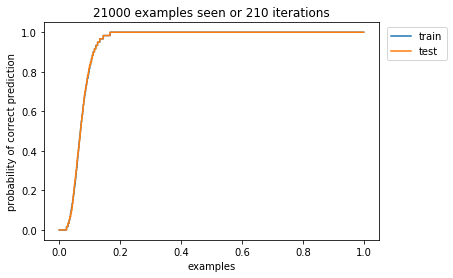

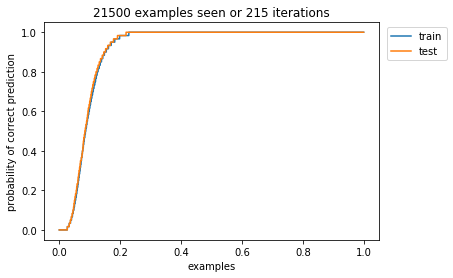

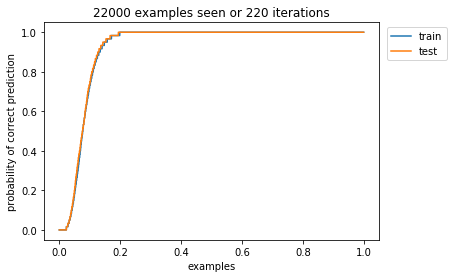

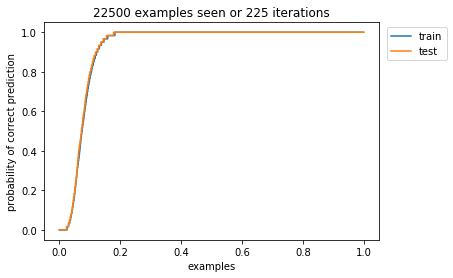

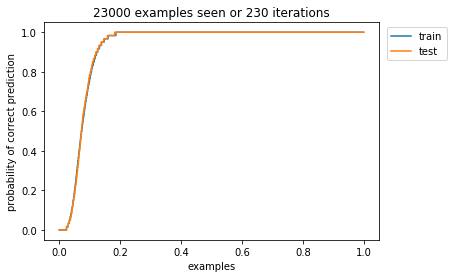

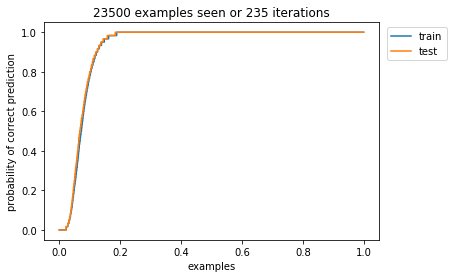

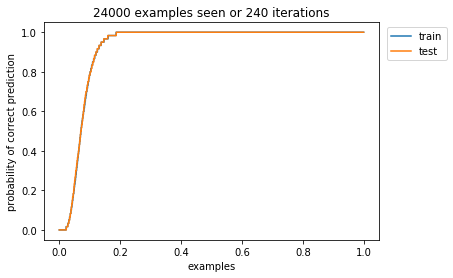

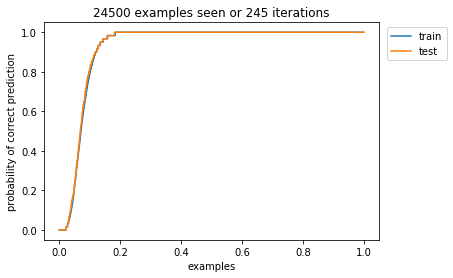

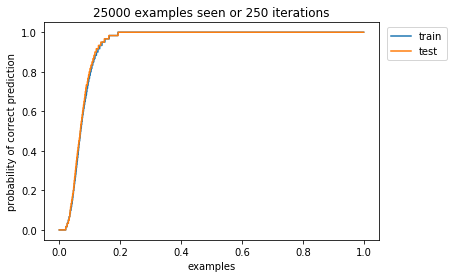

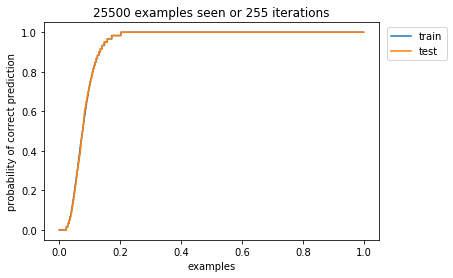

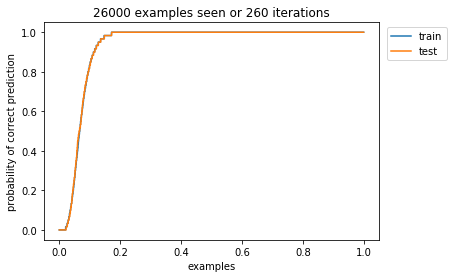

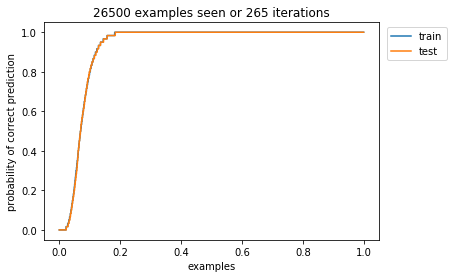

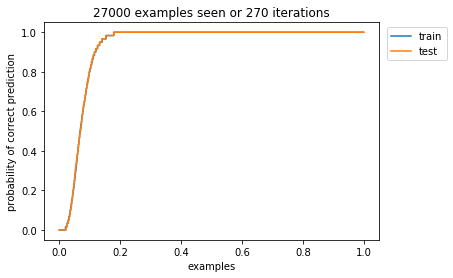

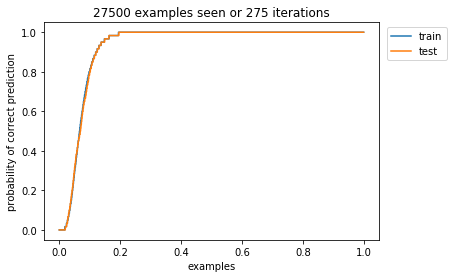

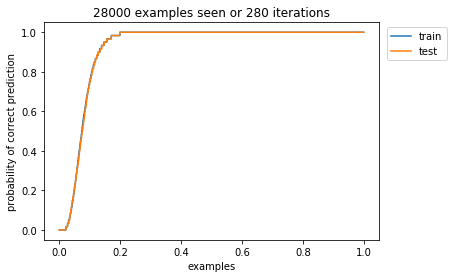

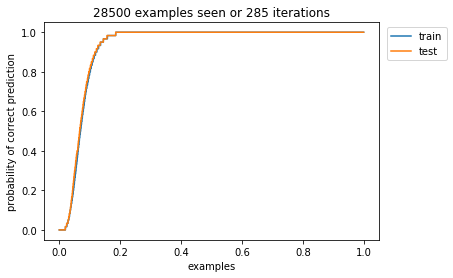

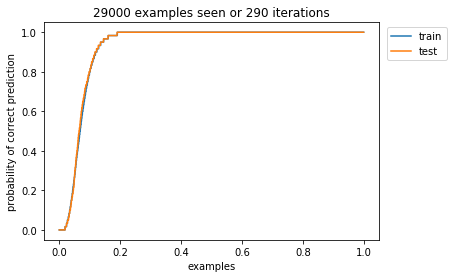

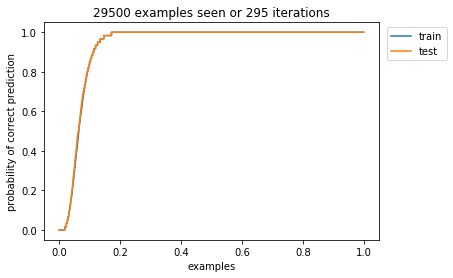

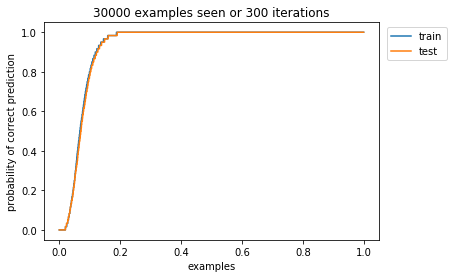

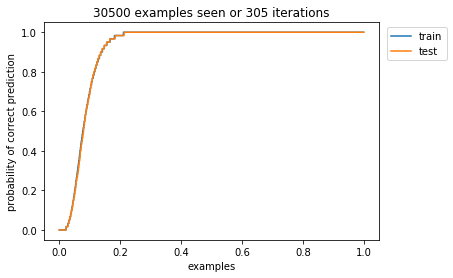

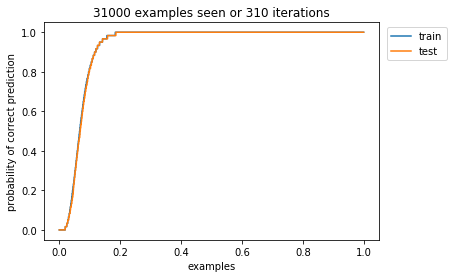

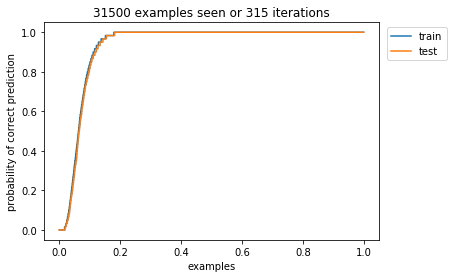

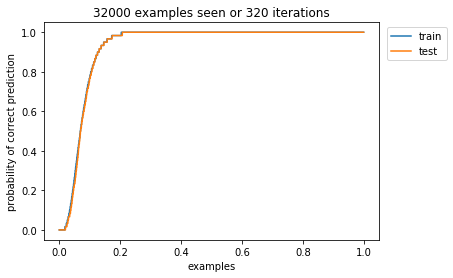

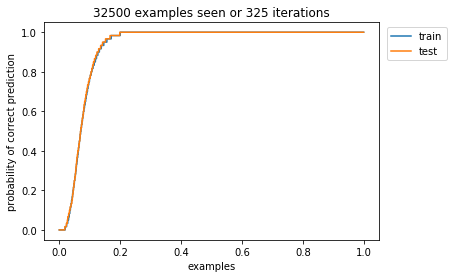

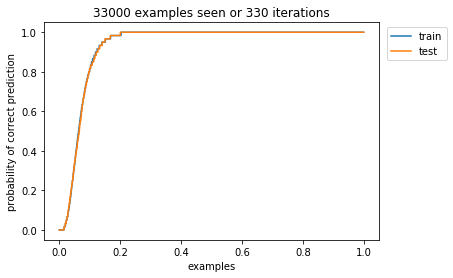

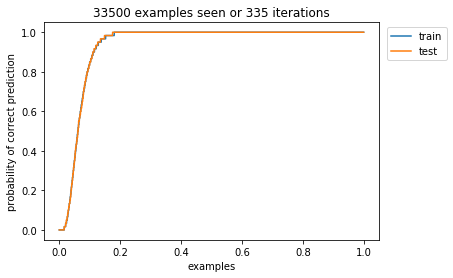

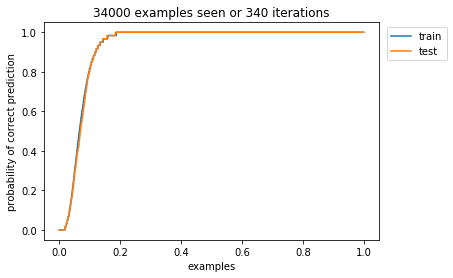

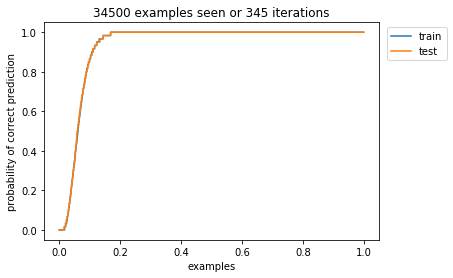

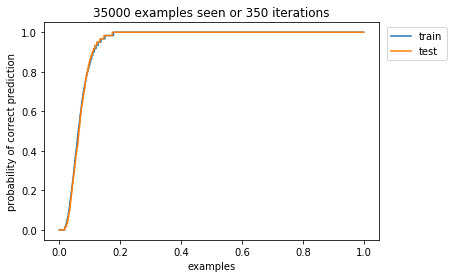

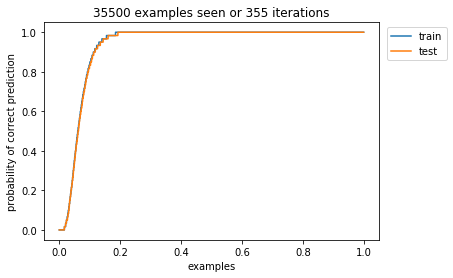

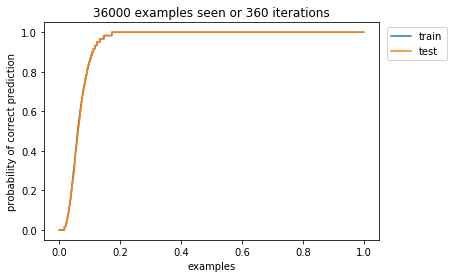

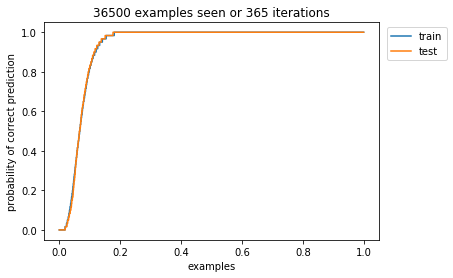

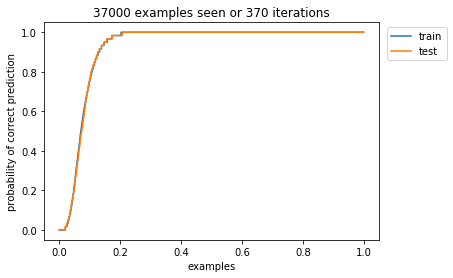

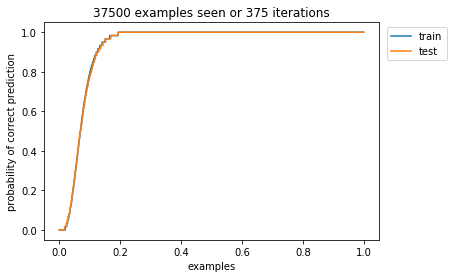

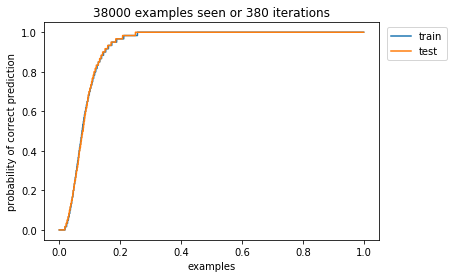

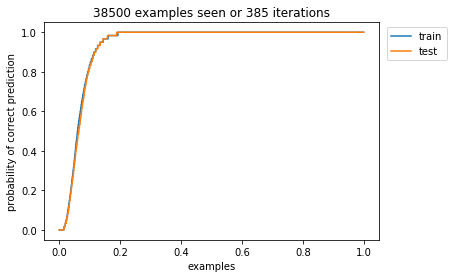

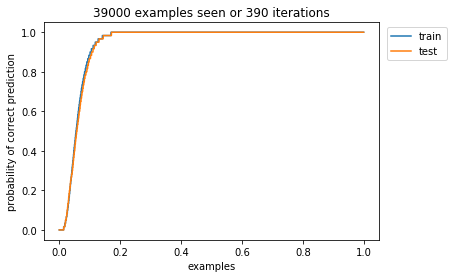

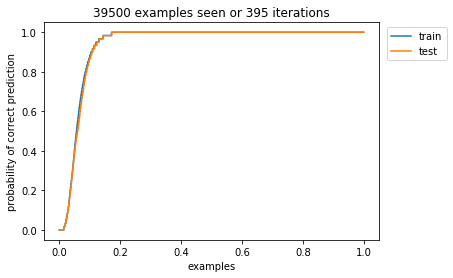

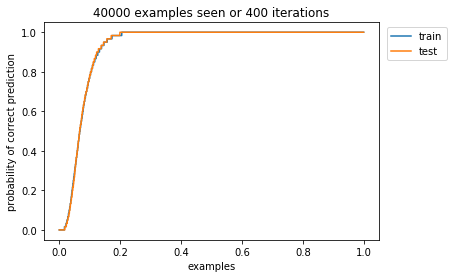

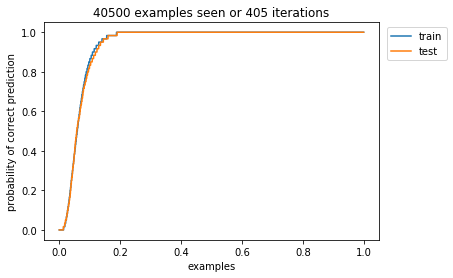

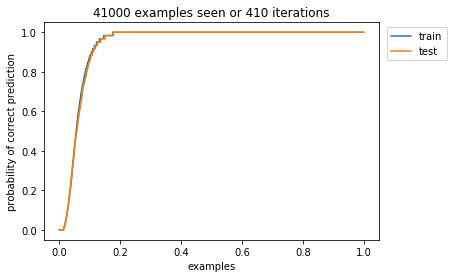

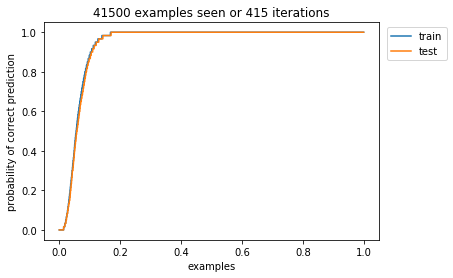

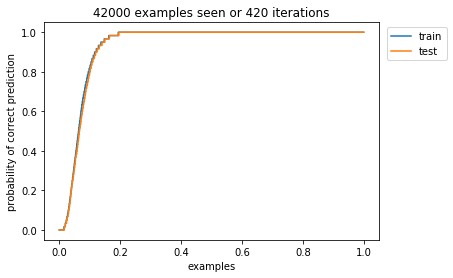

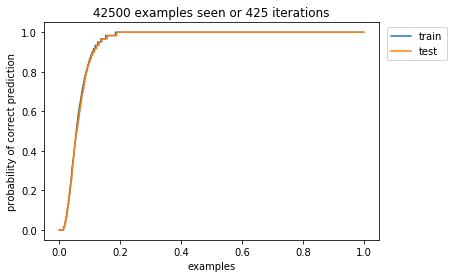

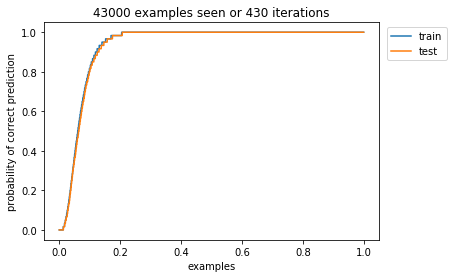

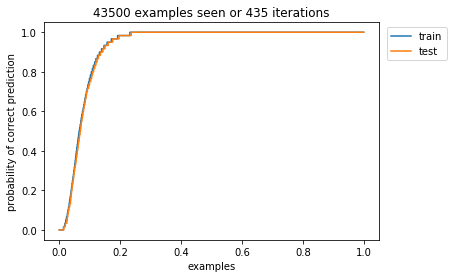

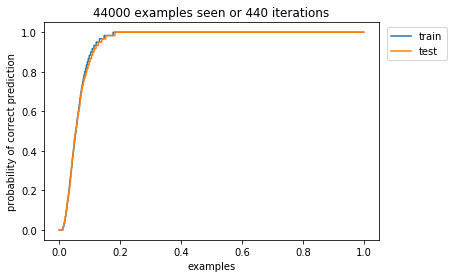

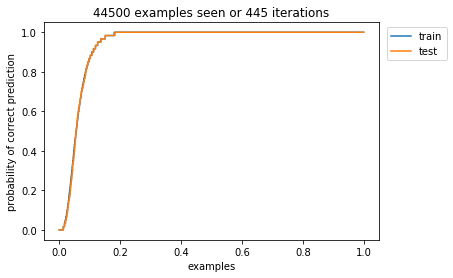

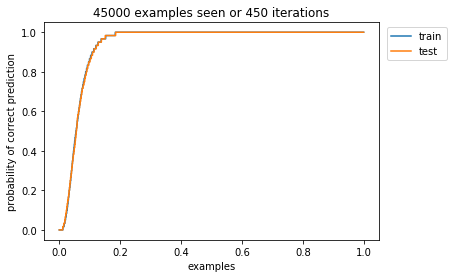

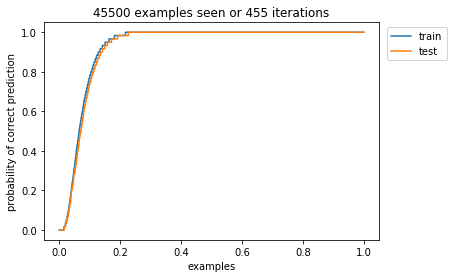

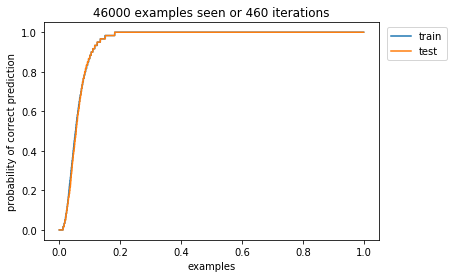

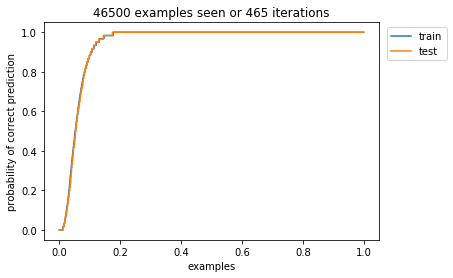

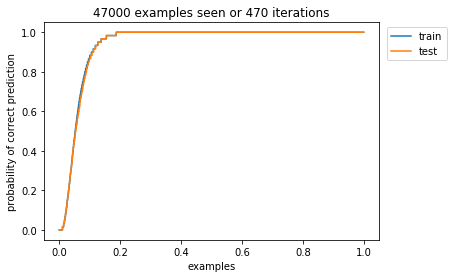

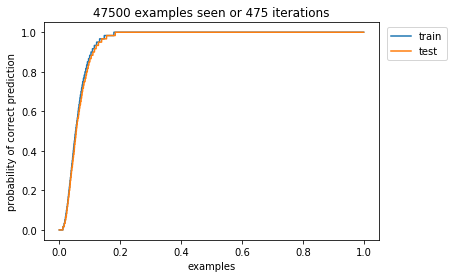

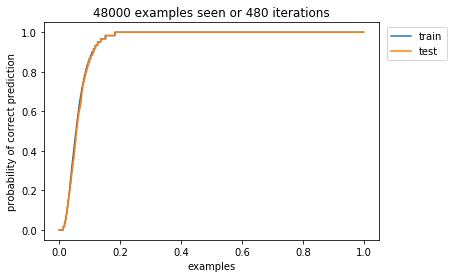

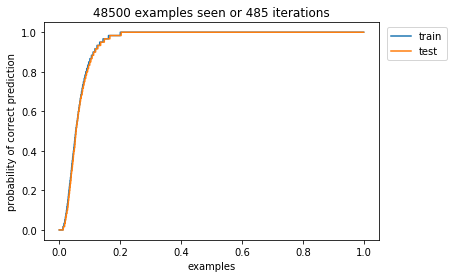

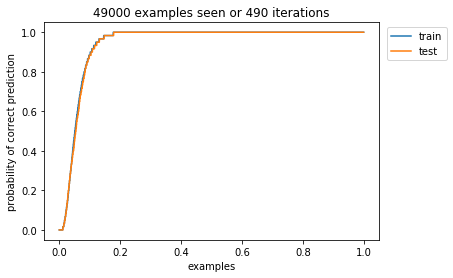

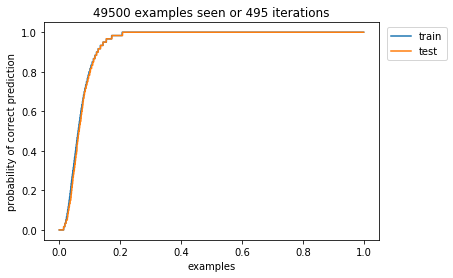

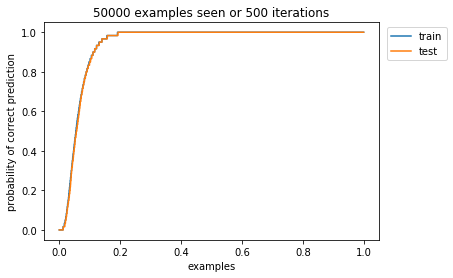

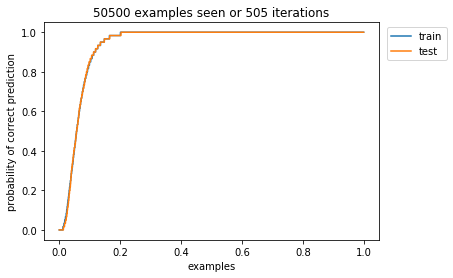

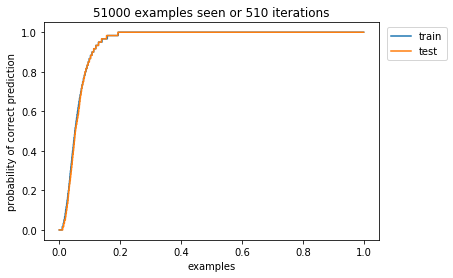

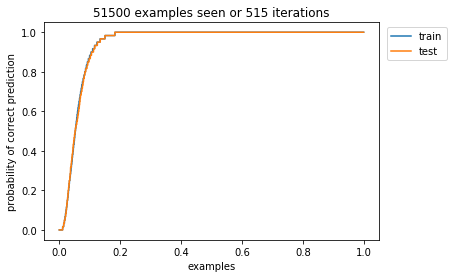

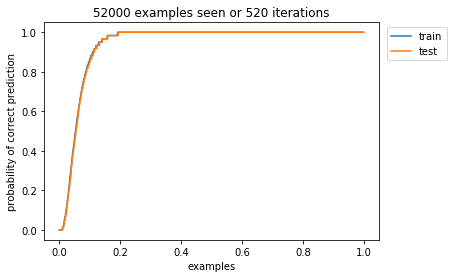

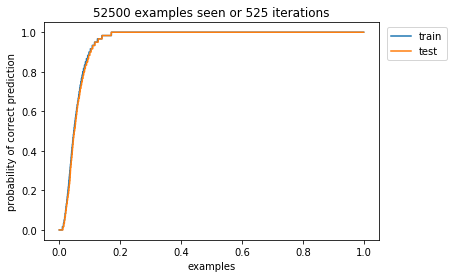

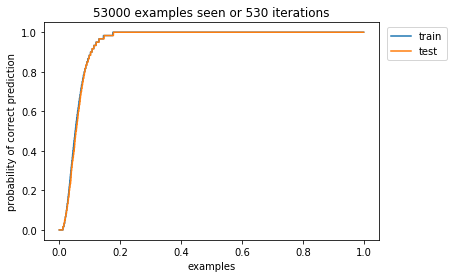

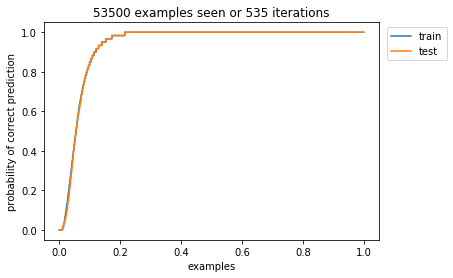

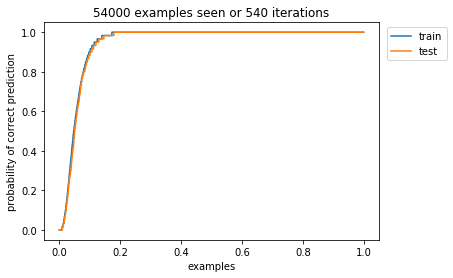

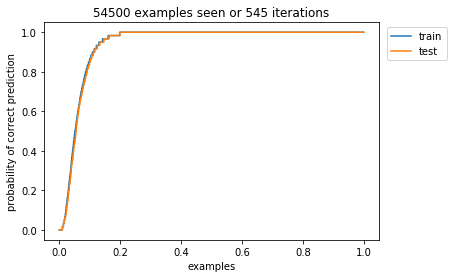

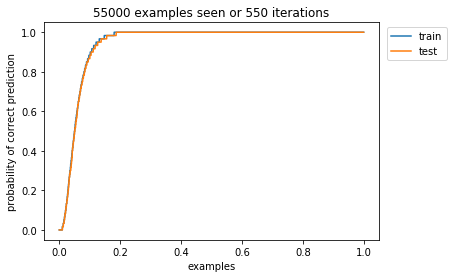

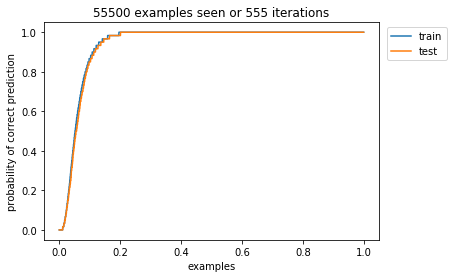

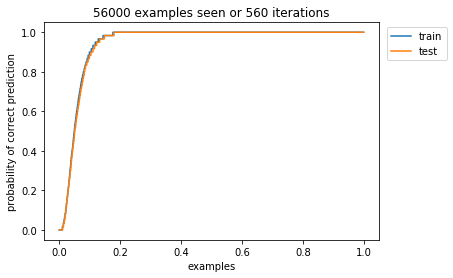

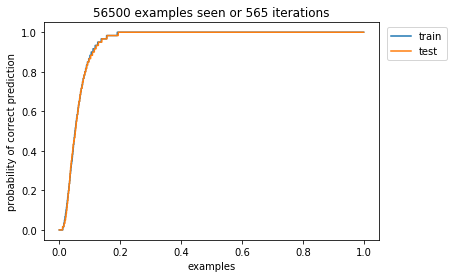

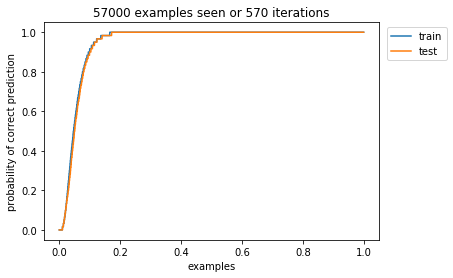

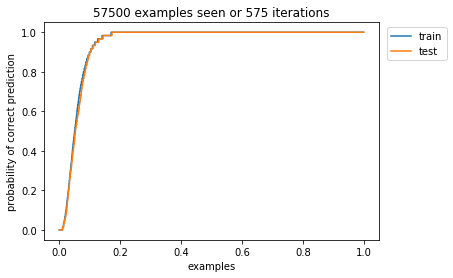

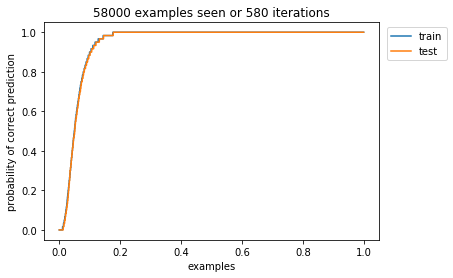

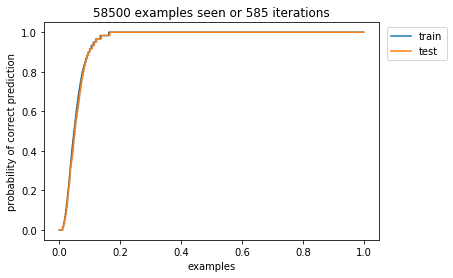

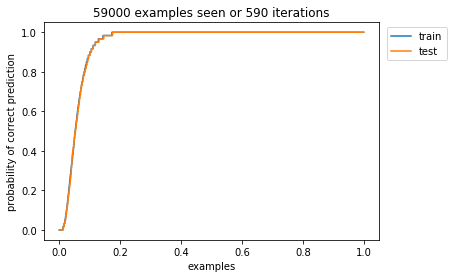

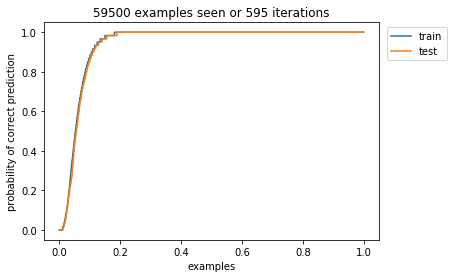

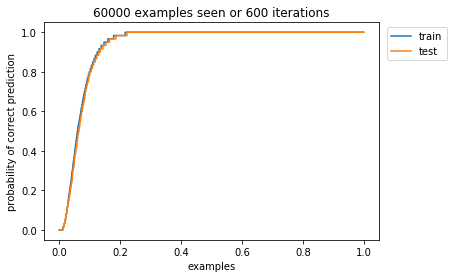

In [61]:
# train and test on top of each other
for i in range(120 + 1):
    plt.figure()
    plot_opt_point_both(train_ps[i], test_ps[i], '{} examples seen or {} iterations'.format(500 * i, 5 * i))

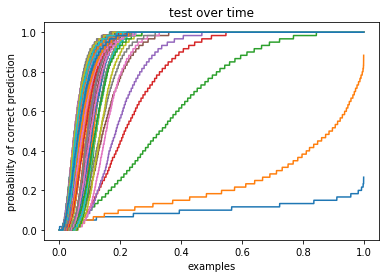

In [62]:
# test over time (roughly the same as train)
for i in range(120 + 1):
    plot_opt_point_probs(test_ps[i], 'test over time')

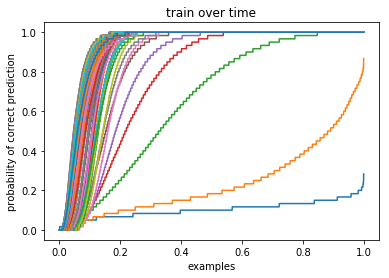

In [63]:
# train over time (roughly the same as above)
for i in range(120 + 1):
    plot_opt_point_probs(train_ps[i], 'train over time')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_first_epoch(train_ps=None, test_ps=None, opt_paths=None, num_hidden=25, num_runs=60, num_inters=120):
    if train_ps is None or test_ps is None:
        if opt_paths is None:
            train_opt_paths, test_opt_paths = get_fine_opt_paths(num_hidden, num_runs, num_inters)
        else:
            train_opt_paths, test_opt_paths = opt_paths
        train_ps = opt_paths_to_sorted_ps(train_opt_paths)
        test_ps = opt_paths_to_sorted_ps(test_opt_paths)
    
    plt.figure()
    for i in range(num_inters):
        ps, _ = get_iter_probs(num_hidden, num_runs, i)
        plot_opt_point_probs(ps, 'Network with {} hidden units on training set'.format(num_hidden),
                             xlabel='examples sorted by p', epoch=(i + 1) / 10)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
    plt.figure()
    for i in range(num_iters):
        _, ps = get_iter_probs(num_hidden, num_runs, i)
        plot_opt_point_probs(ps, 'Network with {} hidden units on test set'.format(num_hidden),
                             xlabel='examples sorted by p', epoch=(i + 1) / 10)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        
    get_iter_probs(25, 100, 0)

In [4]:
train_opt_paths, test_opt_paths = get_opt_paths(25, NUM_RUNS, SLURM_ID, include_fine=True)

In [4]:
import numpy as np
from math import sqrt
from infmetrics import get_pairwise_hamming_diffs
def get_mean_std_hamm_diffs(opt_paths, non_id=True):
    n_indep = len(opt_paths[0])
    means = []
    stds = []
    for i in range(len(train_opt_paths)):
        if non_id:
            ps = get_probs(opt_paths[i])
            dists, _ = get_pairwise_hamming_diffs(opt_paths[i], ps=ps)
        else:
            dists, _ = get_pairwise_hamming_diffs(opt_paths[i])
        means.append(np.mean(dists))
        stds.append(np.std(dists) / sqrt(n_indep))
    return means, stds

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_errorbars(means, stds, title, label, include_fine=False):
    if include_fine:
        x = [0] + [i / 10 for i in range(1, 11)] + list(range(1, 11))
    else:
        x = list(len(means))
    plt.title(title)
    print('len(x):', len(x))
    print('len(means):', len(means))
    plt.errorbar(x, means, yerr=[2 * std for std in stds], capsize=5, label=label)
    plt.xlabel('epoch')
    plt.ylabel('mean hamming distance (subtracted expectation)')

len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21


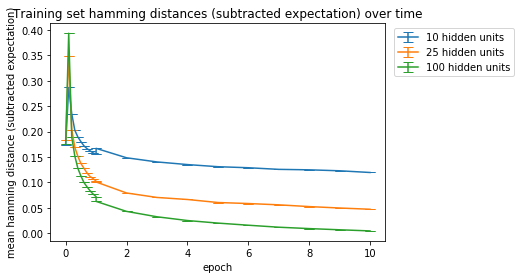

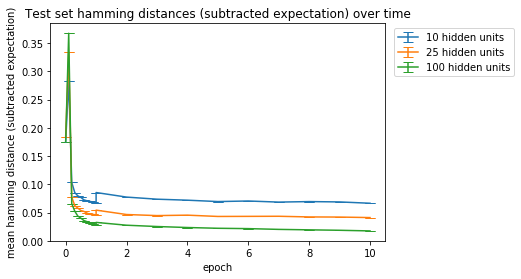

In [8]:
# Without identically distributed assumption, just plotting the expectation
for num_hidden in HIDDEN_SIZES:
    train_opt_paths, test_opt_paths = get_opt_paths(num_hidden, NUM_RUNS, SLURM_ID, include_fine=True)
    
    means, stds = get_mean_std_hamm_diffs(train_opt_paths)
    plt.figure('train')
    plot_errorbars(means, stds, 'Training set hamming distances (subtracted expectation) over time',
                   '{} hidden units'.format(num_hidden), include_fine=True)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
    means, stds = get_mean_std_hamm_diffs(test_opt_paths)
    plt.figure('test')
    plot_errorbars(means, stds, 'Test set hamming distances (subtracted expectation) over time',
                   '{} hidden units'.format(num_hidden), include_fine=True)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21


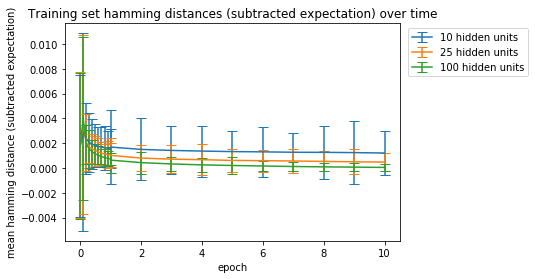

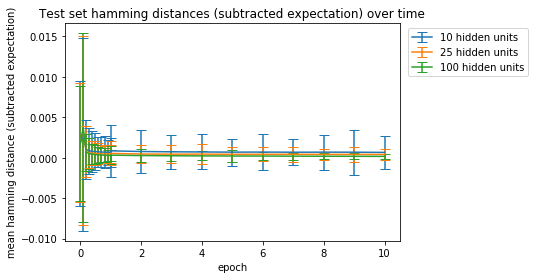

In [6]:
# Without identically distributed assumption
for num_hidden in HIDDEN_SIZES:
    train_opt_paths, test_opt_paths = get_opt_paths(num_hidden, NUM_RUNS, SLURM_ID, include_fine=True)
    
    means, stds = get_mean_std_hamm_diffs(train_opt_paths)
    plt.figure('train')
    plot_errorbars(means, stds, 'Training set hamming distances (subtracted expectation) over time',
                   '{} hidden units'.format(num_hidden), include_fine=True)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
    means, stds = get_mean_std_hamm_diffs(test_opt_paths)
    plt.figure('test')
    plot_errorbars(means, stds, 'Test set hamming distances (subtracted expectation) over time',
                   '{} hidden units'.format(num_hidden), include_fine=True)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21


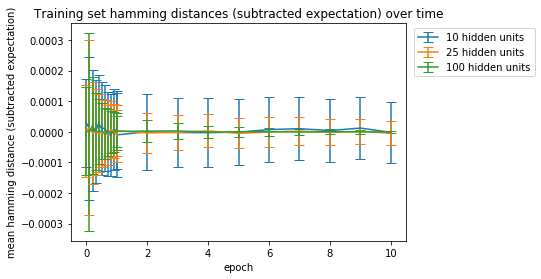

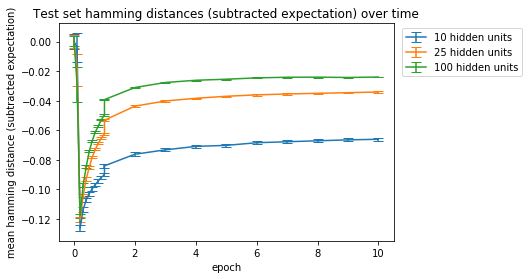

In [13]:
# With identically distributed assumption
for num_hidden in HIDDEN_SIZES:
    train_opt_paths, test_opt_paths = get_opt_paths(num_hidden, NUM_RUNS, SLURM_ID, include_fine=True)
    
    means, stds = get_mean_std_hamm_diffs(train_opt_paths, non_id=False)
    plt.figure('train')
    plot_errorbars(means, stds, 'Training set hamming distances (subtracted expectation) over time',
                   '{} hidden units'.format(num_hidden), include_fine=True)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
    means, stds = get_mean_std_hamm_diffs(test_opt_paths, non_id=False)
    plt.figure('test')
    plot_errorbars(means, stds, 'Test set hamming distances (subtracted expectation) over time',
                   '{} hidden units'.format(num_hidden), include_fine=True)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

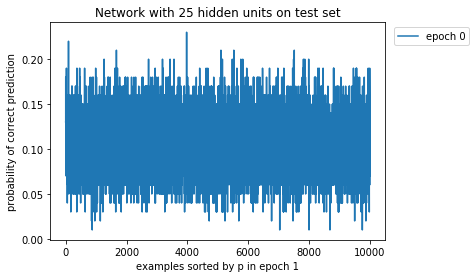

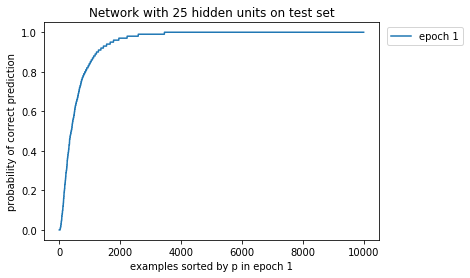

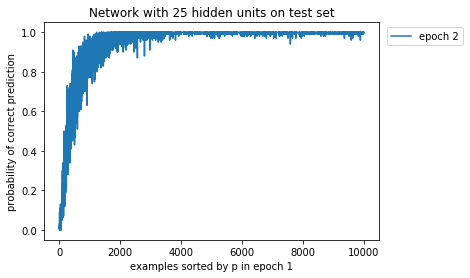

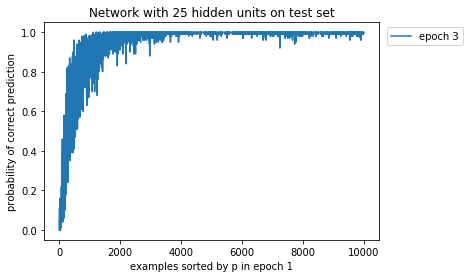

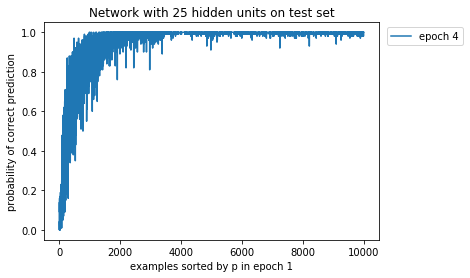

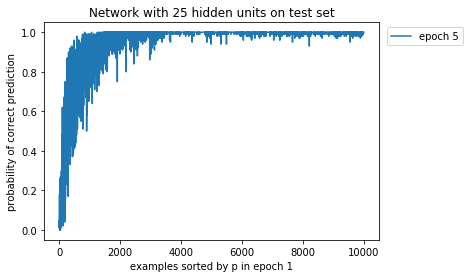

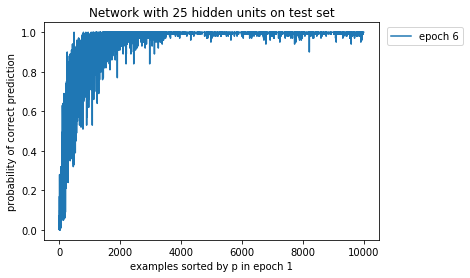

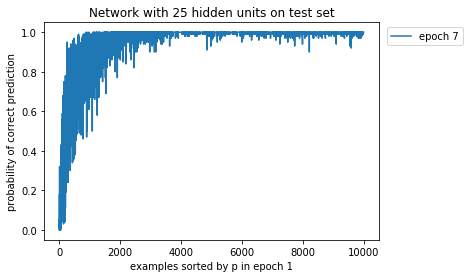

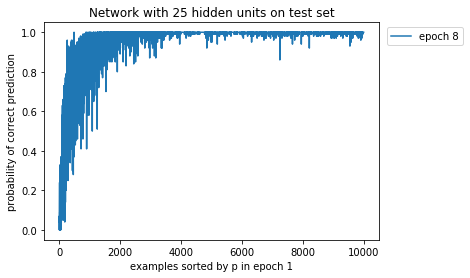

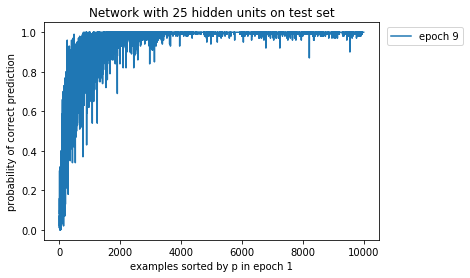

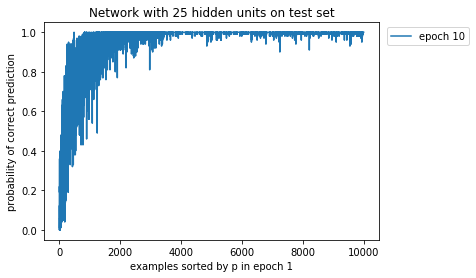

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_opt_paths(num_hidden, num_runs=NUM_RUNS, slurm_id=SLURM_ID, separate_plots=False):
    train_opt_paths, test_opt_paths = get_opt_paths(num_hidden, num_runs, slurm_id)
    train_opt_ps = opt_paths_to_ordered_ps(train_opt_paths)
    test_opt_ps = opt_paths_to_ordered_ps(test_opt_paths)
    
#     plt.figure()
    for epoch, ps in enumerate(train_opt_ps):
        if separate_plots:
            plt.figure()
        plot_opt_point_probs(ps, 'Network with {} hidden units on training set'.format(num_hidden),
                             xlabel='examples sorted by p in epoch 1', epoch=epoch)
        plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
    plt.figure()
    for epoch, ps in enumerate(test_opt_ps):
        if separate_plots:
            plt.figure()
        plot_opt_point_probs(ps, 'Network with {} hidden units on test set'.format(num_hidden),
                             xlabel='examples sorted by p in epoch 1', epoch=epoch)
        plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
# for num_hidden in HIDDEN_SIZES:
#     plot_opt_paths(num_hidden)
plt.close('all')
plot_opt_paths(25, separate_plots=True)

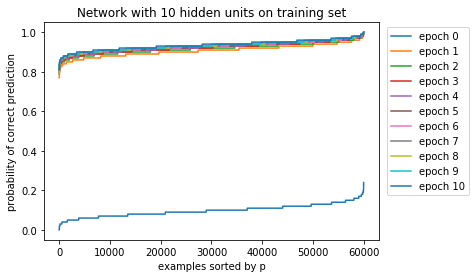

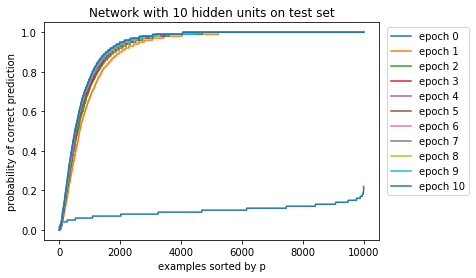

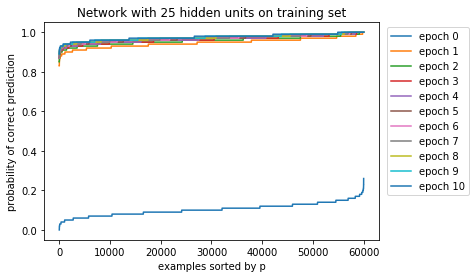

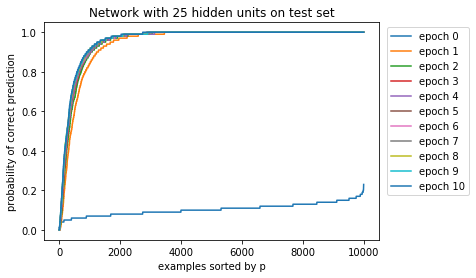

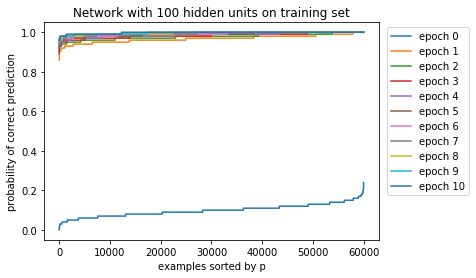

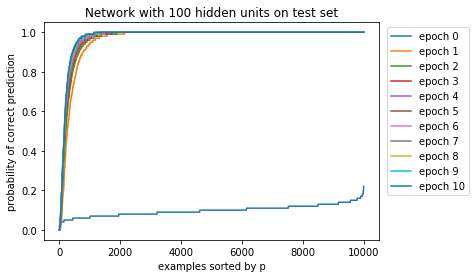

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_sorted_opt_paths(num_hidden, num_runs=NUM_RUNS, slurm_id=SLURM_ID):
    train_opt_paths, test_opt_paths = get_opt_paths(num_hidden, num_runs, slurm_id)
    train_opt_ps = opt_paths_to_sorted_ps(train_opt_paths)
    test_opt_ps = opt_paths_to_sorted_ps(test_opt_paths)
    
    plt.figure()
    for epoch, ps in enumerate(train_opt_ps):
        plot_opt_point_probs(ps, 'Network with {} hidden units on training set'.format(num_hidden),
                             xlabel='examples sorted by p', epoch=epoch)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
    plt.figure()
    for epoch, ps in enumerate(test_opt_ps):
        plot_opt_point_probs(ps, 'Network with {} hidden units on test set'.format(num_hidden),
                             xlabel='examples sorted by p', epoch=epoch)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
for num_hidden in HIDDEN_SIZES:
    plot_sorted_opt_paths(num_hidden)

In [5]:
from fileio import load_fine_path_train_bitmaps, load_fine_path_test_bitmaps

def get_iter_probs(num_hidden, num_runs, i):
    train_bitmaps = [load_fine_path_train_bitmaps(num_hidden, run_i, i) for run_i in range(num_runs)]
    test_bitmaps = [load_fine_path_test_bitmaps(num_hidden, run_i, i) for run_i in range(num_runs)]
    return get_sorted_probs(train_bitmaps), get_sorted_probs(test_bitmaps)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_first_epoch(num_hidden, num_runs=100, num_iters=10):
    plt.figure()
    for i in range(num_iters):
        ps, _ = get_iter_probs(num_hidden, num_runs, i)
        plot_opt_point_probs(ps, 'Network with {} hidden units on training set'.format(num_hidden),
                             xlabel='examples sorted by p', epoch=(i + 1) / 10)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
    plt.figure()
    for i in range(num_iters):
        _, ps = get_iter_probs(num_hidden, num_runs, i)
        plot_opt_point_probs(ps, 'Network with {} hidden units on test set'.format(num_hidden),
                             xlabel='examples sorted by p', epoch=(i + 1) / 10)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        
    get_iter_probs(25, 100, 0)

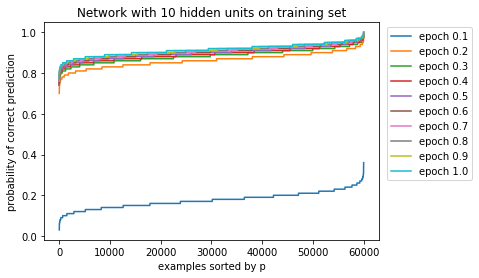

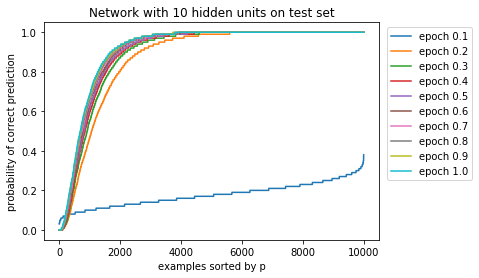

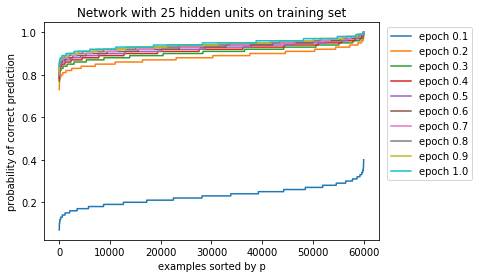

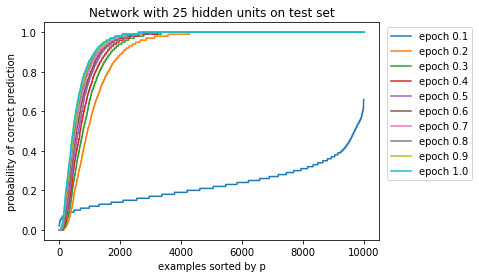

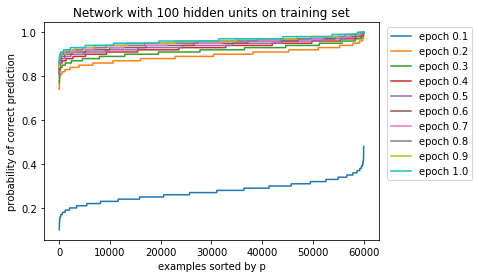

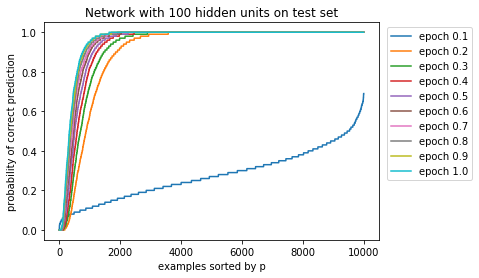

In [13]:
for num_hidden in HIDDEN_SIZES:
    plot_first_epoch(num_hidden)